### Installing Libraries

In [ ]:
# @title
!pip install sparknlp
!pip install pyspark
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.6/547.6 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=f5cb529913f9a9f36da8f4f71b781bbf74bbf6879fc55340ebdb4c6acd5261aa
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.8 MB/s eta 0:00:00


### Import

In [ ]:
from tqdm import tqdm
import pandas as pd

import sparknlp
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
from sparknlp.annotator import *
from sparknlp.base import *
import pyspark.sql.functions as F
from sparknlp.training import CoNLL
from sklearn.metrics import classification_report

from datasets import load_dataset

### Dataset Loader and Preprocessor

In [ ]:
# @title
dataset = load_dataset("ncbi_disease")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 5433
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 924
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 941
    })
})

In [ ]:
# @title
def dataset_to_conll(type, file_save):

    # dataset to dataframe
    data_dict = {
        'sent_id': [],
        'token': [],
        'entity_label': []
    }

    for i in tqdm(range(len(dataset[type]))):
        for id, tk, lb in zip(dataset[type][i]['id'], dataset[type][i]['tokens'], dataset[type][i]['ner_tags']):
            data_dict['sent_id'].append(id)
            data_dict['token'].append(tk)
            data_dict['entity_label'].append(lb)

    ncbi = pd.DataFrame.from_dict(data_dict)
    ncbi['pos']='NN'

    # dataframe to conll
    conll_lines="-DOCSTART- -X- -X- -O-\n\n"
    save = 0
    count = 1

    for sent, token, pos, label in zip(ncbi['sent_id'],ncbi['token'],ncbi['pos'],ncbi['entity_label']):
        if count == 8500:
            print('broke')
            break
        count += 1
        if save!=sent:
            conll_lines+='\n'
        conll_lines += "{} {} {} {}\n".format(token, pos, pos, label)
        save=sent

    with open(file_save,'w') as txtfile:
        for line in conll_lines:
            txtfile.write(line)


In [ ]:
dataset_to_conll('train', 'ncbi_train.txt')
dataset_to_conll('test', 'ncbi_test.txt')
dataset_to_conll('validation', 'ncbi_validation.txt')

100%|██████████| 5433/5433 [00:04<00:00, 1354.60it/s]


broke


100%|██████████| 924/924 [00:00<00:00, 1437.46it/s]


In [ ]:
# training
file_loc = 'ncbi_train.txt'

with open(file_loc,'r') as f:
    lines=f.readlines()

len(lines)

16091

In [ ]:
# testing
file_loc = 'ncbi_test.txt'

with open(file_loc,'r') as f:
    lines=f.readlines()

len(lines)

5139

### Spark Session

In [ ]:
spark = sparknlp.start(memory="12G")
spark

In [ ]:
max_epochs = 10

## NerCRF

### Training

In [ ]:
train = CoNLL().readDataset(spark, file_loc)

In [ ]:
train.select(F.explode(F.arrays_zip('token','label')).alias("cols")) \
.select(F.expr("cols.token").alias("token"),
        F.expr("cols.label").alias("ground_truth"))\
        .groupBy('ground_truth.result').count()\
        .orderBy('count', ascending=False).show(100,truncate=False)

+------+-----+
|result|count|
+------+-----+
|0     |2533 |
|1     |90   |
|2     |80   |
+------+-----+



In [ ]:
word_embeddings = WordEmbeddingsModel.pretrained('glove_100d')\
          .setInputCols(["document", "token"])\
          .setOutputCol("embeddings")

glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[OK!]


In [ ]:
nerTagger = NerCrfApproach()\
    .setInputCols(["sentence", "token", "pos","embeddings"])\
    .setLabelColumn("label")\
    .setOutputCol("ner")\
    .setMaxEpochs(max_epochs)

ner_pipeline = Pipeline(stages=[
          word_embeddings,
          nerTagger
 ])

### Runner

In [ ]:
%%time

ner_model = ner_pipeline.fit(train)

CPU times: user 91.1 ms, sys: 15 ms, total: 106 ms
Wall time: 10.5 s


### Testing

In [ ]:
# testing
file_loc = 'ncbi_test.txt'
test = CoNLL().readDataset(spark, file_loc)

test.select(F.explode(F.arrays_zip('token','label')).alias("cols")) \
.select(F.expr("cols.token").alias("token"),
        F.expr("cols.label").alias("ground_truth"))\
        .groupBy('ground_truth.result').count()\
        .orderBy('count', ascending=False).show(100,truncate=False)

+------+-----+
|result|count|
+------+-----+
|0     |2533 |
|1     |90   |
|2     |80   |
+------+-----+



In [ ]:
test_data = word_embeddings.transform(test)

In [ ]:
predictions = ner_model.transform(test_data)

In [ ]:
predictions.columns

['text', 'document', 'sentence', 'token', 'pos', 'label', 'embeddings', 'ner']

In [ ]:
preds = predictions.select(F.explode(F.arrays_zip('token','label','ner'))).alias("cols")\
            .select(
            F.col('col.token.result').alias("token"),
            F.col('col.label.result').alias("label"),
            F.col('col.ner.result').alias("ner"))

### Results

In [ ]:
preds_df=preds.toPandas()
print (classification_report(preds_df['label'], preds_df['ner']))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      2533
           1       0.82      0.30      0.44        90
           2       1.00      0.09      0.16        80

    accuracy                           0.95      2703
   macro avg       0.92      0.46      0.52      2703
weighted avg       0.95      0.95      0.93      2703



### Scrap

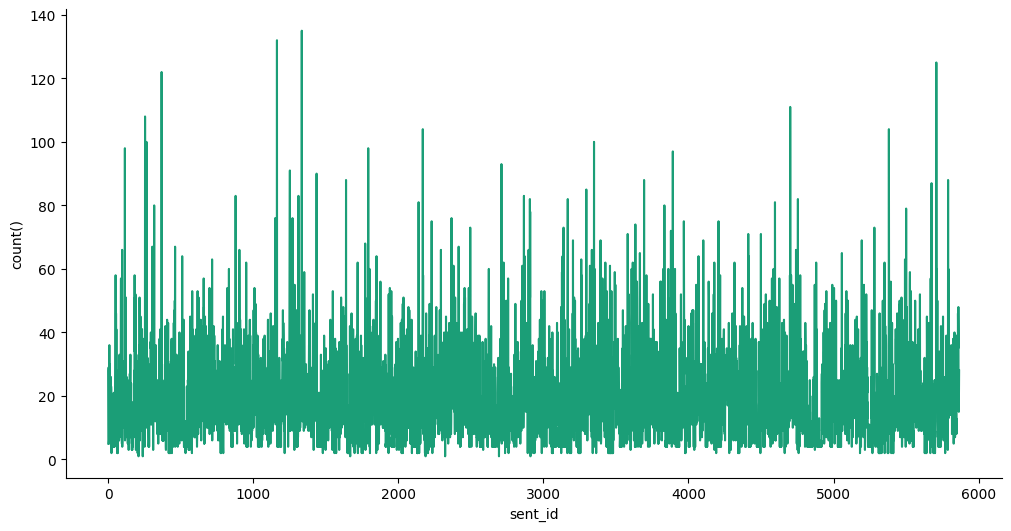

In [ ]:
# @title
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['sent_id']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'sent_id'}, axis=1)
              .sort_values('sent_id', ascending=True))
  xs = counted['sent_id']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df2.sort_values('sent_id', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('sent_id')
_ = plt.ylabel('count()')

In [ ]:
# @title
import json
from itertools import chain
import datasets

class BioNLP2004Config(datasets.BuilderConfig):
    """BuilderConfig"""

    def __init__(self, **kwargs):
        """BuilderConfig.
        Args:
          **kwargs: keyword arguments forwarded to super.
        """
        super(BioNLP2004Config, self).__init__(**kwargs)


class BioNLP2004(datasets.GeneratorBasedBuilder):

    def _split_generators(self, dl_manager):
        downloaded_file = dl_manager.download_and_extract(_URLS)
        return [datasets.SplitGenerator(name=i, gen_kwargs={"filepaths": downloaded_file[str(i)]})
                for i in [datasets.Split.TRAIN, datasets.Split.VALIDATION, datasets.Split.TEST]]

    def _generate_examples(self, filepaths):
        _key = 0
        for filepath in filepaths:
            with open(filepath, encoding="utf-8") as f:
                _list = [i for i in f.read().split('\n') if len(i) > 0]
                for i in _list:
                    data = json.loads(i)
                    yield _key, data
                    _key += 1

    def _info(self):
        return datasets.DatasetInfo(
            features=datasets.Features(
                {
                    "tokens": datasets.Sequence(datasets.Value("string")),
                    "tags": datasets.Sequence(datasets.Value("int32")),
                }
            )
        )

In [ ]:
# relevant version.
# You5:33 PM
# https://files.pythonhosted.org/packages/f8/f5/94645111948708b946f5c0f51c503b287db529e2dca6af816fa3e652b49b/transformers-2.8.0.tar.gz
# MOHAMMED DANISH Ansari5:40 PM
# https://www.youtube.com/watch?v=gAkwW2tuIqE
# MOHAMMED DANISH Ansari6:49 PM
# https://github.com/bnajlis/named_entity_recognition/blob/master/Name%20Entity%20Recognition%20with%20Deep%20Learning.ipynb
# MOHAMMED DANISH Ansari7:19 PM
# https://huggingface.co/datasets/tner/bionlp2004/blob/main/bionlp2004.py

## NerDL

### Training

In [ ]:
word_embeddings = WordEmbeddingsModel.pretrained('glove_100d')\
          .setInputCols(["document", "token"])\
          .setOutputCol("embeddings")

glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[OK!]


In [ ]:
train_data = word_embeddings.transform(train)
test_data = word_embeddings.transform(test)
test_data.write.parquet('./test.parquet', mode="overwrite")

In [ ]:
nerTagger = NerDLApproach()\
  .setInputCols(["sentence", "token", "embeddings"])\
  .setLabelColumn("label")\
  .setOutputCol("ner")\
  .setMaxEpochs(max_epochs)\
  .setLr(0.001)\
  .setPo(0.005)\
  .setBatchSize(32)\
  .setRandomSeed(0)\
  .setVerbose(1)\
  .setValidationSplit(0.2)\
  .setEvaluationLogExtended(True) \
  .setEnableOutputLogs(True)\
  .setIncludeConfidence(True)\
  .setTestDataset('./test.parquet')

ner_pipeline = Pipeline(stages=[
          word_embeddings,
          nerTagger
 ])

### Runner

In [ ]:
%%time

ner_model = ner_pipeline.fit(train)

CPU times: user 1.15 s, sys: 134 ms, total: 1.29 s
Wall time: 2min 46s


In [ ]:
! cd ~/annotator_logs && ls -lt

total 16
-rw-r--r-- 1 root root 9281 Jan 24 18:23 NerDLApproach_3203e4153c18.log
-rw-r--r-- 1 root root 1556 Jan 24 18:23 NerDLApproach_94d3d736470a.log


In [ ]:
!cat /root/annotator_logs/NerDLApproach_f5766984d240.log

cat: /root/annotator_logs/NerDLApproach_f5766984d240.log: No such file or directory


### Testing

In [ ]:
# testing
file_loc = 'ncbi_test.txt'
test = CoNLL().readDataset(spark, file_loc)

test_data = word_embeddings.transform(test)

In [ ]:
predictions = ner_model.transform(test_data)

In [ ]:
predictions.columns

['text', 'document', 'sentence', 'token', 'pos', 'label', 'embeddings', 'ner']

In [ ]:
preds = predictions.select(F.explode(F.arrays_zip('token','label','ner'))).alias("cols")\
            .select(
            F.col('col.token.result').alias("token"),
            F.col('col.label.result').alias("label"),
            F.col('col.ner.result').alias("ner"))

### Results

In [ ]:
preds_df=preds.toPandas()
print (classification_report(preds_df['label'], preds_df['ner']))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2533
           1       0.84      0.90      0.87        90
           2       0.92      0.69      0.79        80

    accuracy                           0.98      2703
   macro avg       0.92      0.86      0.88      2703
weighted avg       0.98      0.98      0.98      2703



## NER BERT

### Training

In [ ]:
bert_annotator = BertEmbeddings.pretrained('small_bert_L2_128', 'en') \
 .setInputCols(["sentence",'token'])\
 .setOutputCol("bert")\
.setBatchSize(8)

small_bert_L2_128 download started this may take some time.
Approximate size to download 16.1 MB
[OK!]


In [ ]:
file_loc = 'ncbi_train.txt'
train = CoNLL().readDataset(spark, file_loc)
train_data = bert_annotator.transform(train)

train_data.show(3)

+--------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|          text|            document|            sentence|               token|                 pos|               label|                bert|
+--------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|Identification|[{document, 0, 13...|[{document, 0, 13...|[{token, 0, 13, I...|[{pos, 0, 13, NN,...|[{named_entity, 0...|[{word_embeddings...|
|           The|[{document, 0, 2,...|[{document, 0, 2,...|[{token, 0, 2, Th...|[{pos, 0, 2, NN, ...|[{named_entity, 0...|[{word_embeddings...|
|       Complex|[{document, 0, 6,...|[{document, 0, 6,...|[{token, 0, 6, Co...|[{pos, 0, 6, NN, ...|[{named_entity, 0...|[{word_embeddings...|
+--------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+

In [ ]:
train_data = train_data.selectExpr("text as text", "document as document", "sentence as sentence", "token as token", "pos as pos", "label as label", "bert as embed")

In [ ]:
train_data.select("embed.result","embed.embeddings",'label.result').show()

+--------------------+--------------------+---------+
|              result|          embeddings|   result|
+--------------------+--------------------+---------+
|    [identification]|[[-1.9077102, 1.0...|      [0]|
|               [the]|[[-1.8922291, 1.1...|      [0]|
|           [complex]|[[-2.3408303, 0.4...|      [0]|
|                [in]|[[-1.313936, 0.96...|      [0]|
|              [here]|[[-1.2980142, 0.1...|      [0]|
|         [mammalian]|[[-1.1073264, 0.7...|      [0]|
|              [like]|[[-0.9329141, 0.3...|      [0]|
|             [human]|[[-1.7062587, 0.1...|      [0]|
|                 [3]|[[-1.2693504, 0.1...|      [0]|
|               [apc]|[[-1.5407237, 0.0...|      [0]|
|                 [a]|[[-2.0839546, 1.1...|      [0]|
|            [common]|[[-1.3609346, 0.8...|      [0]|
|[the, frequency, ...|[[-1.6004143, 1.1...|[0, 0, 0]|
|          [mutation]|[[-1.6087823, 0.5...|      [0]|
|          [although]|[[-1.3503674, 0.9...|      [0]|
|              [this]|[[-2.3

In [ ]:
train_data.write.parquet("test_withEmbeds.parquet", mode="overwrite")

In [ ]:
nerTagger = NerDLApproach()\
  .setInputCols(["sentence", "token", "embed"])\
  .setLabelColumn("label")\
  .setOutputCol("ner")\
  .setMaxEpochs(max_epochs)\
  .setLr(0.001)\
  .setPo(0.005)\
  .setBatchSize(max_epochs)\
  .setEvaluationLogExtended(True) \
  .setEnableOutputLogs(True)\
  .setTestDataset("test_withEmbeds.parquet")

pipeline = Pipeline(
    stages = [
    bert_annotator,
    nerTagger
  ])

### Runner

In [ ]:
%%time

ner_model = pipeline.fit(train_data)

CPU times: user 2.44 s, sys: 249 ms, total: 2.69 s
Wall time: 6min 47s


In [ ]:
!ls -l /root/annotator_logs/ | cat

total 8
-rw-r--r-- 1 root root 5341 Jan 25 08:39 NerDLApproach_750536522098.log


In [ ]:
!cat /root/annotator_logs/NerDLApproach_96acff8848bc.log

cat: /root/annotator_logs/NerDLApproach_96acff8848bc.log: No such file or directory


### Testing

In [ ]:
# testing
file_loc = 'ncbi_test.txt'
test = CoNLL().readDataset(spark, file_loc)

test_data = bert_annotator.transform(test)

In [ ]:
test_data = test_data.selectExpr("text as text", "document as document", "sentence as sentence", "token as token", "pos as pos", "label as label", "bert as embed")
predictions = ner_model.transform(test_data)

In [ ]:
predictions.columns

['text',
 'document',
 'sentence',
 'token',
 'pos',
 'label',
 'embed',
 'bert',
 'ner']

In [ ]:
preds = predictions.select(F.explode(F.arrays_zip('token','label','ner'))).alias("cols")\
            .select(
            F.col('col.token.result').alias("token"),
            F.col('col.label.result').alias("label"),
            F.col('col.ner.result').alias("ner"))

### Results

In [ ]:
preds_df=preds.toPandas()
print (classification_report(preds_df['label'], preds_df['ner']))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2533
           1       0.60      0.57      0.58        90
           2       0.63      0.33      0.43        80

    accuracy                           0.96      2703
   macro avg       0.74      0.63      0.66      2703
weighted avg       0.95      0.96      0.95      2703

